drzewo decyzyjne: https://www.kaggle.com/jiashenliu/who-can-earn-more-than-50k-per-year
outliers: https://www.kaggle.com/kazimanil/adult-census-income-classification



In [202]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno

In [203]:
df = pd.read_csv('tmp.csv')

In [204]:
# wyrzucam dane ktorych nie ma
df = df.replace(' Not in universe', np.nan)
df = df.replace(' ?', np.nan)
df = df.replace(' Not in universe or children', np.nan)

In [205]:
education_mapping = {" Children": 0,
                     " Less than 1st grade": 1,
                     " 1st 2nd 3rd or 4th grade": 2,
                     " 5th or 6th grade": 3,
                     " High school graduate": 4,
                     " 7th and 8th grade": 5,
                     " 9th grade": 6,
                     " 10th grade": 7,
                     " 11th grade": 8,
                     " 12th grade no diploma": 9,
                     " Some college but no degree": 10,
                     " Bachelors degree(BA AB BS)": 11,
                     " Masters degree(MA MS MEng MEd MSW MBA)": 12,
                     " Associates degree-occup /vocational": 13,
                     " Associates degree-academic program": 14,
                     " Doctorate degree(PhD EdD)": 15,
                     " Prof school degree (MD DDS DVM LLB JD)": 16}

df.replace(education_mapping, inplace=True)
df['education'] = df['education'].astype('category')

In [5]:
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran’s admin,veterans benefits,weeks worked in year,year,salary
0,73,NaN,0,0,4,0,NaN,Widowed,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,10,0,NaN,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
2,18,NaN,0,0,7,0,High school,Never married,NaN,NaN,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.
3,9,NaN,0,0,0,0,NaN,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
4,10,NaN,0,0,0,0,NaN,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.


In [206]:
# salary mapping
salary_mapping = {' - 50000.': 0,
                 ' 50000+.': 1}
df.replace(salary_mapping, inplace=True)

In [7]:
# sex mapping
sex_mapping = {' Female': 0,
                 ' Male': 1}

df.replace(sex_mapping, inplace=True)

In [207]:
# maritial status mapping
maritial_mapping = {'divorced': [' Divorced'],
                   'single': [' Never married', ' Widowed'],
                   'married': [' Married-A F spouse present', 
                               ' Married-civilian spouse present',
                              ' Married-spouse absent', ' Separated']}
df.replace('divocred', 'divorced', inplace=True)
df.replace([' Never married', ' Widowed'], 'single', inplace=True)
df.replace(maritial_mapping['married'], 'married', inplace=True)


In [208]:
# citizenship status mapping
citizenship_mapping = {'native': [' Native- Born in the United States',
                                  ' Native- Born in Puerto Rico or U S Outlying',
                                  ' Native- Born abroad of American Parent(s)'],
                    'foreign': [' Foreign born- Not a citizen of U S ',
                               ' Foreign born- U S citizen by naturalization'],
                   }
df.replace(citizenship_mapping['native'], 'native', inplace=True)
df.replace(citizenship_mapping['foreign'], 'foreign', inplace=True)


In [209]:
def remove_col_append_dummies(dataset, col_name):
    # z danej kolumny robie dummies 
    prefix = 'col_' + str(col_name)
    dummies = pd.get_dummies(dataset[col_name], prefix=prefix)
#     dummies = dummies.drop(dummies.columns[len(dummies.columns)-1], axis=1) # usuwam ostatnia
    dataset = df.drop(col_name, axis=1)
    dataset = pd.concat([dataset, dummies], axis=1)
    return dataset

In [210]:
# zamiana w one hot
cats_to_one_hot = ['class of worker', 'marital stat', 'major industry code', 
                   'major occupation code', 'race', 'reason for unemployment',
                  'full or part time employment stat', 'tax filer stat', 'sex']
for c in cats_to_one_hot:
    df = remove_col_append_dummies(df, c)

In [211]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.columns, len(numerical_features.columns)

(Index(['age', 'detailed industry recode', 'detailed occupation recode',
        'education', 'wage per hour', 'capital gains', 'capital losses',
        'dividends from stocks', 'instance weight',
        'num persons worked for employer', 'own business or self employed',
        'veterans benefits', 'weeks worked in year', 'year', 'salary',
        'col_class of worker_ Federal government',
        'col_class of worker_ Local government',
        'col_class of worker_ Never worked', 'col_class of worker_ Private',
        'col_class of worker_ Self-employed-incorporated',
        'col_class of worker_ Self-employed-not incorporated',
        'col_class of worker_ State government',
        'col_class of worker_ Without pay', 'col_marital stat_ Divorced',
        'col_marital stat_married', 'col_marital stat_single',
        'col_major industry code_ Agriculture',
        'col_major industry code_ Armed Forces',
        'col_major industry code_ Business and repair services',
        

Tutaj widzę które dane nie są zawarte. Widać, że enroll in edu inst last wk można zupełnie pominąć. Co do innych należy się zastanowić.

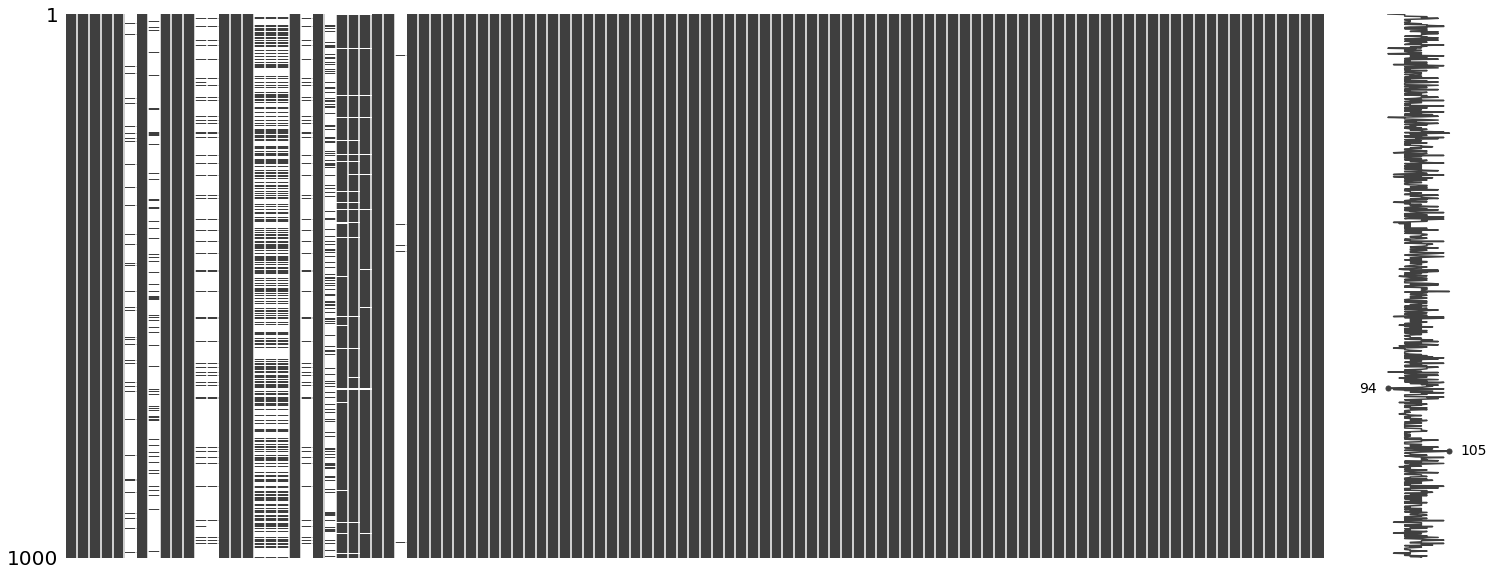

In [212]:
msno.matrix(df.sample(1000))

Tutaj widzę które brakujące wartości są ze sobą powiązane. Tzn. jeśli nie ma "major industry code" to nie ma również "major occupation code". Co ciekawe istnieje ujemna korelacja dla "famili member under 18". Trzeba to zbadać.

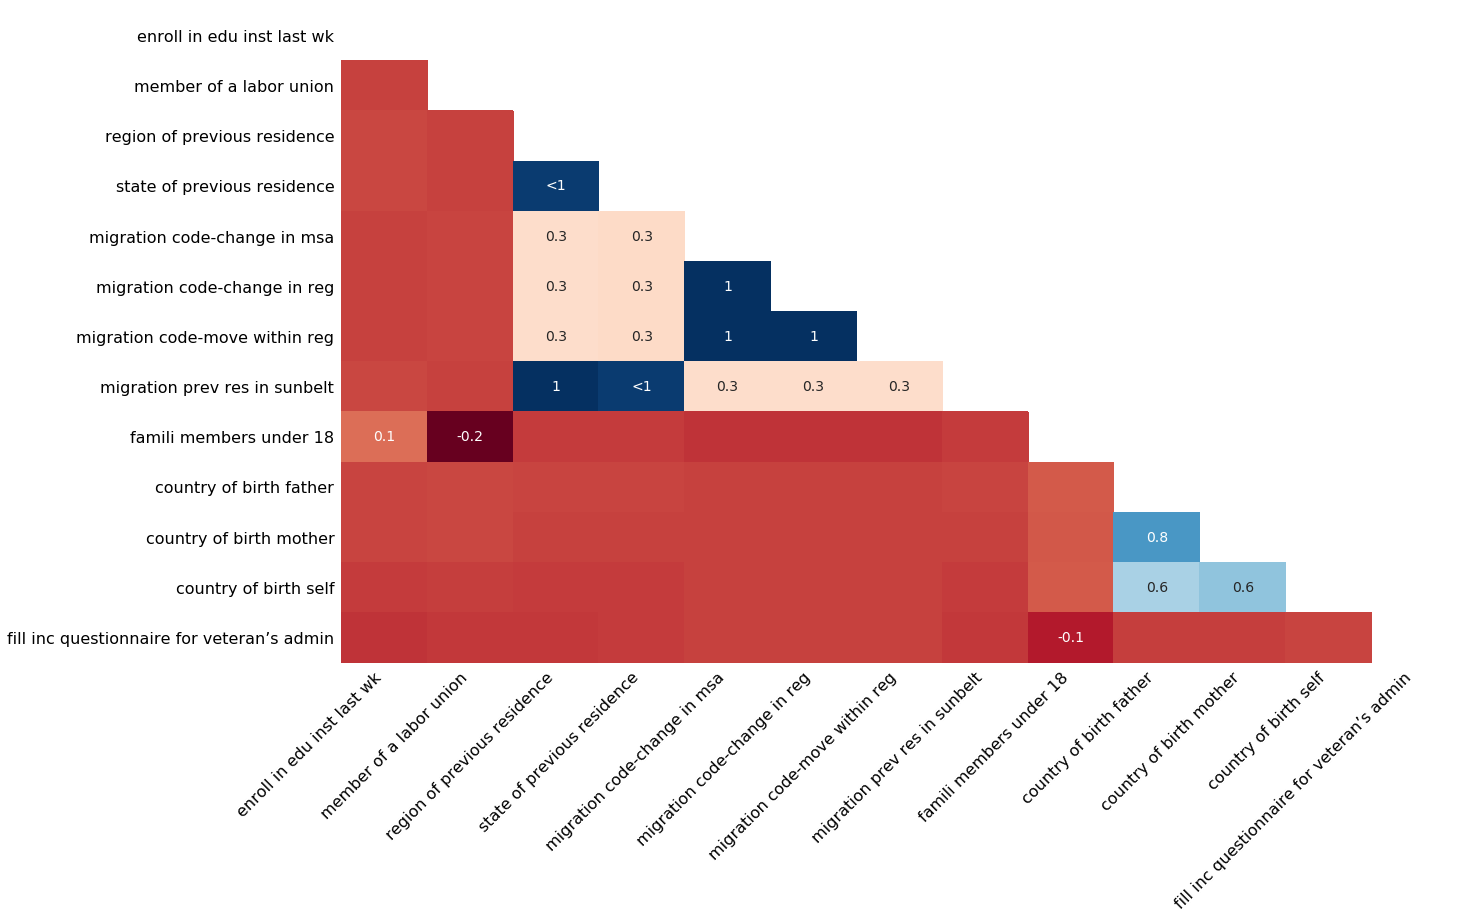

In [213]:
msno.heatmap(df)

Ile pustych rekordów dla kategorycznych rekordów:

In [15]:
cat_df = df.select_dtypes(include=['object', 'category']).copy()
cat_df.isnull().sum()

enroll in edu inst last wk                    186943
hispanic origin                                    0
member of a labor union                       180459
region of previous residence                  183750
state of previous residence                   184458
detailed household and family stat                 0
detailed household summary in household            0
migration code-change in msa                  101212
migration code-change in reg                  101212
migration code-move within reg                101212
live in this house 1 year ago                      0
migration prev res in sunbelt                 183750
famili members under 18                       144232
country of birth father                         6713
country of birth mother                         6119
country of birth self                           3393
citizenship                                        0
fill inc questionnaire for veteran’s admin    197539
dtype: int64

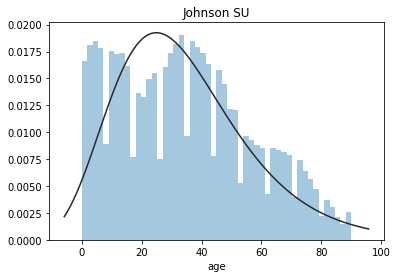

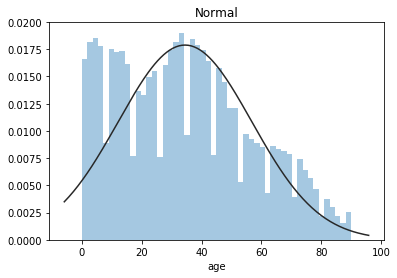

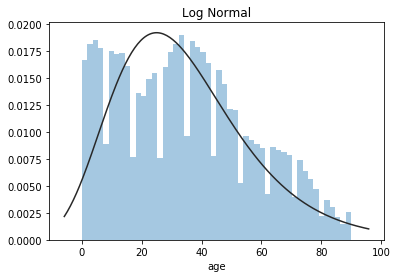

In [16]:
y = df['age']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

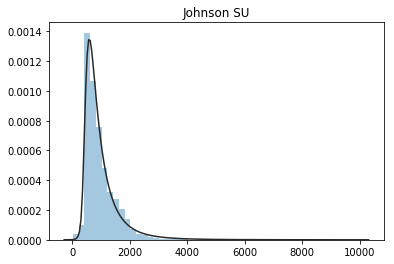

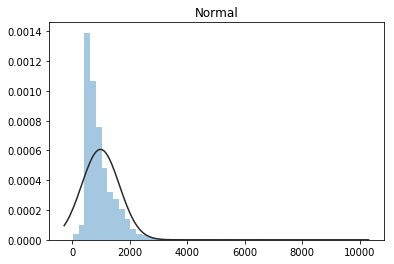

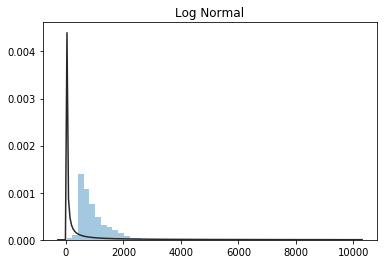

In [17]:
y = [t for t in df['wage per hour'] if t > 0] # rekordy gdzie nie ma zarobkow sa do bani
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

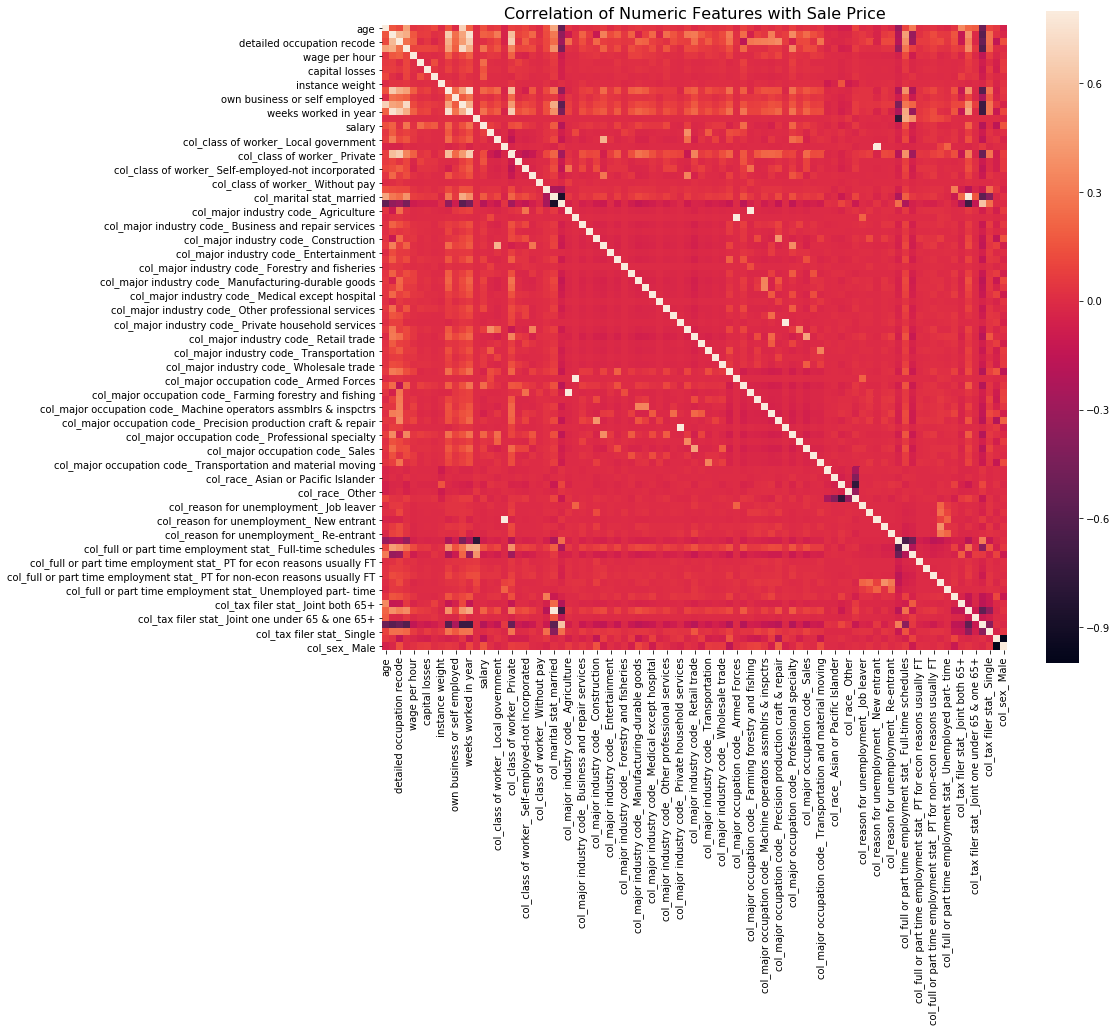

In [214]:
correlation = numerical_features.corr()
f , ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)

In [215]:
data_corr=df.corr(method='pearson')
data_corr.sort_values('salary').salary

col_tax filer stat_ Nonfiler                                       -0.198326
col_marital stat_single                                            -0.189925
col_sex_ Female                                                    -0.157610
col_full or part time employment stat_ Children or Armed Forces    -0.077344
col_full or part time employment stat_ Not in labor force          -0.073197
col_major occupation code_ Other service                           -0.054909
col_race_ Black                                                    -0.049827
col_major occupation code_ Adm support including clerical          -0.037592
col_major occupation code_ Handlers equip cleaners etc             -0.025852
col_reason for unemployment_ Re-entrant                            -0.021233
col_race_ Other                                                    -0.021054
col_major industry code_ Retail trade                              -0.020078
col_major occupation code_ Machine operators assmblrs & inspctrs   -0.018996